# Building ARPES SRCNN in pytorch

Repeating the result of [SR-CNN](https://github.com/avdfo/PHYS_549_package) but in pytorch.

In [5]:
import math
from inspect import isfunction
from functools import partial


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# %matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np

In [2]:
from torch.utils.data import DataLoader, Dataset

In [3]:
import glob

def read_arpes_data(directory, dset_name):
    '''
    load low resolution (noisy) and high resolution arpes data from npy files.
    '''
    hr = []
    lr = []
    
    path_hr = directory + dset_name + "_hr/"
    path_lr = directory + dset_name + "_lr/"
    
    allfiles_hr = glob.glob(path_hr+"*"+".npy")
    allfiles_hr.sort()
    
    allfiles_lr = glob.glob(path_lr+"*"+".npy")
    allfiles_lr.sort()
    
    for one_file in allfiles_hr:
        hr.append(np.load(one_file)[:256,:256].reshape(1,256,256))
        # hr.append(np.load(one_file).reshape(1,300,300))
        
    for one_file in allfiles_lr:
        lr.append(np.load(one_file)[:256,:256].reshape(1,256,256))
        # lr.append(np.load(one_file).reshape(1,300,300))
        
    hr = np.stack(hr, axis = 0)
    lr = np.stack(lr, axis = 0)
    
    return hr, lr
    
    
    
    

In [20]:
train_hr, train_lr = read_arpes_data("/stor0/reallsx/arpes/", "train")
val_hr, val_lr = read_arpes_data("/stor0/reallsx/arpes/", "validation")

In [5]:
# train_hr = train_hr * 2 - 1
# train_lr = train_lr * 2 - 1

In [7]:
train_hr.shape

(1600, 1, 256, 256)

In [8]:
class apres_dataset(Dataset):
    def __init__(self, hr, lr):
        if len(hr) != len(lr):
            raise ValueError("Inputs must have the same length")
        
        self.hr = hr
        self.lr = lr

    def __len__(self):
        return len(self.hr)

    def __getitem__(self, index):
        x = torch.from_numpy(self.hr[index])
        y = torch.from_numpy(self.lr[index])
        return {'HR':x, 'SR':y}

In [21]:
train_dataset = apres_dataset(train_hr, train_lr)
val_dataset = apres_dataset(val_hr, val_lr)

In [13]:
print(torch.cuda.is_available())
# torch.cuda.set_device(1)
print(torch.cuda.current_device())

True
0


In [14]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, stride=1, padding="same")
        # self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        # self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding="same")
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, stride=1, padding="same")
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.sigmoid(x)
        return x


In [44]:
from torch.nn import init

def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()

In [82]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = "cuda" if torch.cuda.is_available() else "cpu"

model = SRCNN().to(device)
model.apply(weights_init_orthogonal)


# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()

optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor = 0.5, cooldown = 5)

In [61]:
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=True)

In [42]:
# a small function provided by chatGPT to control GPU temperature

import time
import os

def get_gpu_temperature(gpu_id = 0):
    try:
        output = os.popen('nvidia-smi --query-gpu=temperature.gpu --format=csv').read().strip().split('\n')[1+gpu_id]
        temperature = int(output)
        return temperature
    except Exception as e:
        print(f'Error getting GPU temperature: {str(e)}')
        return None
    
def gpu_cooldown(gpu_id = 0, upper_lim = 90, lower_lim = 75, sleep_time = 30):
    temp = get_gpu_temperature(gpu_id)
    if temp < upper_lim:
        return
    else:
        while(temp > lower_lim):
            time.sleep(sleep_time)
            temp = get_gpu_temperature(gpu_id)
        return

In [83]:
epochs = 100

training_loss = []
validation_loss = []

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            for key in data:
                data[key] = data[key].to(device)
            outputs = model(data['SR'])
            loss = loss_fn(outputs, data['HR'])
            test_loss += loss.item()

    test_loss /= num_batches
    return test_loss

for epoch in range(epochs):
    running_loss = 0.0
    
    model.train()
    
    for i, data in enumerate(train_dataloader):
        
        for key in data:
            data[key] = data[key].to(device)
        
        optimizer.zero_grad()
        outputs = model(data['SR'])
        loss = criterion(outputs, data['HR'])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d, loss: %.3f' % (epoch+1, running_loss/(i+1)))
    training_loss.append(running_loss/(i+1))
    val_loss = test(val_dataloader, model, nn.BCELoss())
    print('val_loss: %.3f' % (val_loss))
    validation_loss.append(val_loss)
    scheduler.step(val_loss)

Epoch 1, loss: 0.436
val_loss: 0.154
Epoch 2, loss: 0.126
val_loss: 0.114
Epoch 3, loss: 0.111
val_loss: 0.107
Epoch 4, loss: 0.105
val_loss: 0.103
Epoch 5, loss: 0.101
val_loss: 0.099
Epoch 6, loss: 0.098
val_loss: 0.097
Epoch 7, loss: 0.095
val_loss: 0.095
Epoch 8, loss: 0.093
val_loss: 0.093
Epoch 9, loss: 0.091
val_loss: 0.091
Epoch 10, loss: 0.089
val_loss: 0.090
Epoch 11, loss: 0.088
val_loss: 0.090
Epoch 12, loss: 0.087
val_loss: 0.089
Epoch 13, loss: 0.086
val_loss: 0.088
Epoch 14, loss: 0.085
val_loss: 0.088
Epoch 15, loss: 0.084
val_loss: 0.087
Epoch 16, loss: 0.084
val_loss: 0.087
Epoch 17, loss: 0.083
val_loss: 0.087
Epoch 18, loss: 0.083
val_loss: 0.086
Epoch 19, loss: 0.082
val_loss: 0.086
Epoch 20, loss: 0.082
val_loss: 0.085
Epoch 21, loss: 0.082
val_loss: 0.085
Epoch 22, loss: 0.081
val_loss: 0.085
Epoch 23, loss: 0.081
val_loss: 0.084
Epoch 24, loss: 0.081
val_loss: 0.084
Epoch 25, loss: 0.081
val_loss: 0.084
Epoch 26, loss: 0.080
val_loss: 0.084
Epoch 27, loss: 0.080

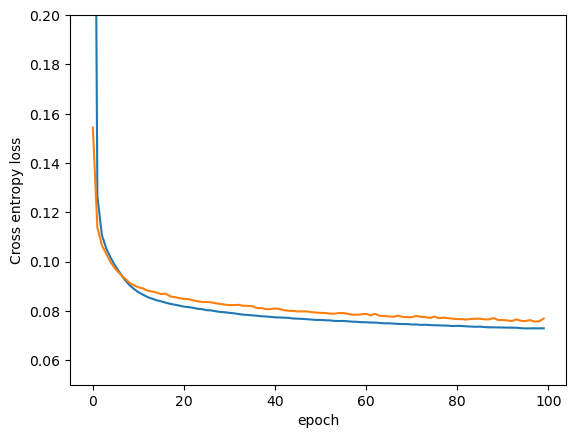

In [85]:

plt.plot(range(len(training_loss)),training_loss)
plt.plot(range(len(validation_loss)),validation_loss)
plt.xlabel("epoch")
plt.ylabel("Cross entropy loss")
plt.ylim(0.05, 0.20)
plt.show()

In [89]:
model.eval()
sample = model(torch.tensor(val_lr[-1].reshape(1,1,256,256)).to(device))

In [90]:
sample_np = sample.cpu().detach().numpy()

In [50]:
sample_np.shape

(1, 1, 256, 256)

In [37]:
def remove_ticks():
    plt.xticks([])
    plt.yticks([])

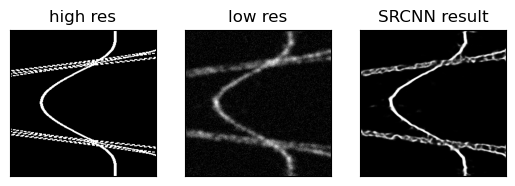

In [91]:
plt.subplot(131)
plt.imshow(val_hr[-1].reshape(256,256),cmap='gray', vmin=0, vmax=1)
plt.title("high res")
remove_ticks()
plt.subplot(132)
plt.imshow(val_lr[-1].reshape(256,256),cmap='gray', vmin=0, vmax=1)
plt.title("low res")
remove_ticks()
plt.subplot(133)
plt.imshow(sample_np.reshape((256,256)), cmap='gray', vmin=0, vmax=1)
plt.title("SRCNN result")
remove_ticks()

In [92]:
PATH = "./srcnn.pt"
torch.save(model.state_dict(), PATH)
